# Ensemble-generation - Pipeline 

#### Please note, the following packages are required

```
!pip install mdtraj
!pip install tqdm
!pip install seedir

```

In [46]:
import mdtraj as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import pairwise_distances_argmin

from math import sqrt
import sys
import os

from datetime import date
from subprocess import call

## Extract features

#### Select your pdb model

In [3]:
project_dir = os.path.dirname(os.getcwd())

In [4]:
project_dir

'/home/andrefonseca/Projects/ensemble-generation'

In [6]:
%%time
top = os.path.join(project_dir + "/data/", "REFprot.pdb")
nstxout = 10
stride = 1
skip = stride * nstxout
dt = 0.002

CPU times: user 31 µs, sys: 5 µs, total: 36 µs
Wall time: 43.4 µs


In [7]:
top

'/home/andrefonseca/Projects/ensemble-generation/data/REFprot.pdb'

#### Select your trajectory file

In [8]:
trajname = os.path.join(project_dir + "/data/", "Crystals.xtc") 
traj = md.load(trajname[:],  stride = stride, top = top)

In [10]:
trajname

'/home/andrefonseca/Projects/ensemble-generation/data/Crystals.xtc'

In [11]:
traj_res = [str(r) for r in traj.top.residues]
print("Total of residues in the structure:", len(traj_res))
print("First residue of chain A:", traj_res[0])

Total of residues in the structure: 73
First residue of chain A: GLN19


In [13]:
cleft1_cA = ["GLN19", "VAL20", "THR21", "CYS22", "GLY23", "THR24", "THR25", "THR26", "LEU27", "ASN28", "PRO39", "ARG40", "HIS41", "VAL42", "ILE43", "CYS44", "THR45", "SER46", "GLU47", "ASP48", "MET49", "LEU50", "ASN51", "PRO52", "TYR54", "LEU57", "CYS85", "ALA116", "CYS117", "TYR118", "ASN119", "TYR126", "ILE136", "LYS137", "GLY138", "SER139", "PHE140", "LEU141", "ASN142", "GLY143", "SER144", "GLY146", "SER147", "TYR161", "MET162", "HIS163", "HIS164", "MET165", "GLU166", "LEU167", "PRO168", "THR169", "GLY170", "VAL171", "HIS172", "ALA173", "GLY174", "THR175", "PHE181", "PRO184", "PHE185", "VAL186", "ASP187", "ARG188", "GLN189", "THR190", "ALA191", "GLN192", "ALA193", "ALA194"]
cleft1_cB = ["ASN214", "GLN299"]

In [14]:
cleft_BS1 = [traj_res.index(r,) for r in cleft1_cA] + [traj_res.index(r) for r in cleft1_cB]
print("Number of residues in BS1:", len(cleft_BS1))
print("Name of first residue in BS1:", traj_res[0])
print("Index of first residue in BS1:", cleft_BS1[0])
print("Index of last residue in BS1:", cleft_BS1[-1])
print("Number of residues in the cA part of BS1:", len(cleft1_cA))
print("Number of residues in the cB part of BS1:", len(cleft1_cB))
print("Index of residues in BS1:", cleft_BS1)


Number of residues in BS1: 72
Name of first residue in BS1: GLN19
Index of first residue in BS1: 0
Index of last residue in BS1: 72
Number of residues in the cA part of BS1: 70
Number of residues in the cB part of BS1: 2
Index of residues in BS1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]


In [15]:
pairs = list(itertools.combinations(cleft_BS1, 2))
print(len(pairs))

2556


## Getting distances

In [16]:
desc = [(str(traj_res[int(p[0])]), str(traj_res[int(p[1])])) for p in pairs]

#### Change the output name

In [17]:
output_dir = os.path.join(project_dir + "/data/", "output_compressed.npz")

In [18]:
output_dir

'/home/andrefonseca/Projects/ensemble-generation/data/output_compressed.npz'

In [19]:
distances, indices = md.compute_contacts(traj, contacts = pairs, scheme = 'closest-heavy')

In [ ]:
np.savez_compressed(output_dir, Y = distances, desc = desc)

In [20]:
distances.shape

(158, 2556)

## Load data

In [21]:
npz_file = np.load(output_dir, allow_pickle = True)

In [22]:
distance_Y = list(npz_file["Y"])
feat_des = npz_file["desc"]

## Random seed

In [23]:
random_state = 100

## PCA Analysis - Sklearn

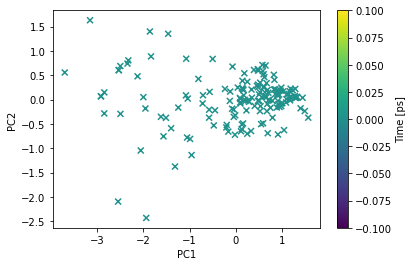

In [24]:
from sklearn.decomposition import PCA

pca_sklearn = PCA(random_state = random_state)
pca_components = pca_sklearn.fit_transform(distance_Y) * -1

plt.figure()
plt.scatter(pca_components[:, 0], pca_components[:,1], marker = 'x', c = traj.time)
plt.xlabel('PC1')
plt.ylabel('PC2')
cbar = plt.colorbar()
cbar.set_label('Time [ps]')

plt.show()

## Free energy calculation

In [25]:
def _to_free_energy(z, minener_zero=False):

    pi = z / float(z.sum())
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = pi.nonzero()
    free_energy[nonzero] = -np.log(pi[nonzero])

    if minener_zero:
        free_energy[nonzero] -= np.min(free_energy[nonzero])
    return free_energy

In [26]:
def get_histogram(
        xall, yall, nbins = 100,
        weights = None, avoid_zero_count = False):
  
    z, xedge, yedge = np.histogram2d(
        xall, yall, bins = nbins, weights = weights)
    
    x = 0.5 * (xedge[:-1] + xedge[1:])
    y = 0.5 * (yedge[:-1] + yedge[1:])

    if avoid_zero_count:
        z = np.maximum(z, np.min(z[z.nonzero()]))
    return x, y, z.T

In [27]:
x, y, z = get_histogram(pca_components[:,0], pca_components[:,1])

In [28]:
kT = 1.0
f = _to_free_energy(z, minener_zero =  True) * kT

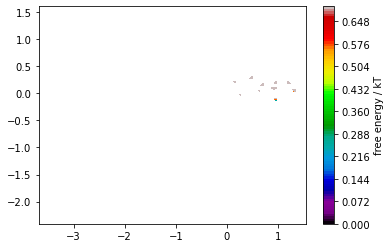

In [29]:
import matplotlib.pyplot as _plt

fig, ax = _plt.subplots()
mappable = ax.contourf(
    x, y, f, 100, norm = None,
    vmin = None, vmax = None, cmap = 'nipy_spectral',
    levels = None)

misc = dict(mappable = mappable)
cbar_ = fig.colorbar(
    mappable, ax = None, orientation = 'vertical')
cbar_.set_label('free energy / kT')

plt.show()

## Variance explained

In [30]:
pca_eigenvalues = pca_sklearn.explained_variance_ratio_

In [31]:
pc_id = list(range(len(pca_eigenvalues)))

In [32]:
pca_eigen_df = pd.DataFrame({"pc_id": pc_id, "eig_cum": np.cumsum(pca_eigenvalues), "eig_values": pca_eigenvalues})

In [33]:
pca_eigen_df.head()

pc_id   eig_cum  eig_values
0      0  0.419203    0.419203
1      1  0.500475    0.081272
2      2  0.568859    0.068384
3      3  0.613444    0.044584
4      4  0.652411    0.038967

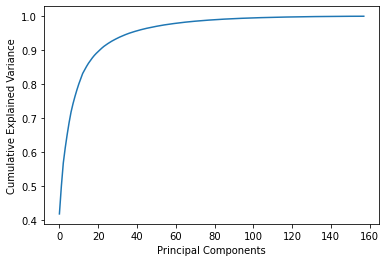

In [34]:
plt.plot(np.cumsum(pca_eigenvalues))
plt.xlabel("Principal Components")
plt.ylabel('Cumulative Explained Variance')
plt.show()

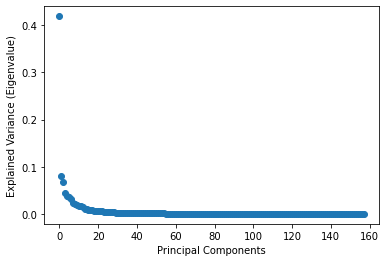

In [35]:
plt.scatter(np.arange(len(pca_eigenvalues)), pca_eigenvalues)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance (Eigenvalue)")
plt.show()

### N of Components

In [36]:
n_pca = pca_eigen_df[pca_eigen_df['eig_cum'] <= 0.7]
n_pca = n_pca.shape[0]

In [37]:
print(n_pca)

6


## Cluster with k-means (scikit learn) over the first k number of PCAs

In [38]:
def optimal_number_of_clusters(wcss):
    # Function to define the optimal number of clusters
    x1, y1 = 1, wcss[0]
    x2, y2 = 100, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [39]:
pca_components_df = pd.DataFrame(pca_components)

### Subsetting PCA components based on explained variance

In [40]:
X = pca_components_df.iloc[:,:n_pca]
X.shape

(158, 6)

In [41]:
inertias = []
K = range(1, 100)

for k in K:
    model = KMeans(n_clusters = k, random_state = random_state)
    model.fit(X)
    inertias.append(model.inertia_)

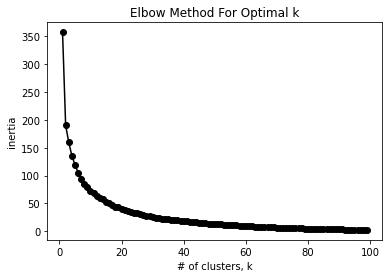

In [42]:
plt.plot(K, inertias, '-o', color='black')
plt.xlabel('# of clusters, k')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')

plt.show()

In [43]:
n = optimal_number_of_clusters(inertias)
print("Optimal number of clusters: ", n)

Optimal number of clusters:  16


In [44]:
km = KMeans(n_clusters = n)
km = km.fit(X)

## Extracting conformations

In [60]:
OPTIONAL = True
execution = date.today().strftime('%Y-%m-%d')

closest = pairwise_distances_argmin(km.cluster_centers_, X)
representatives = []

try:
    os.makedirs(os.path.join(project_dir + "/data/" + "clusters", execution))
except OSError:
    print ("Creation of the directory %s failed" % execution)
else:
    print ("Successfully created the directory %s " % execution)

for i in enumerate(closest):
    traj_index = int((i[1]-1) / traj.n_frames)
    frame_index = i[1]-(traj_index * traj.n_frames)

    n_cluster = str(i[0])
    
    representatives.append([traj_index, frame_index, i[1]])
    print(f"Closest conformation inside cluster {n_cluster} can be found in trajectory {traj_index} frame {frame_index}, (index {i[1]})")

    if OPTIONAL:   
        convert_command = f"mdconvert {trajname} -t {top} -o {project_dir}/data/clusters/{execution}/PCA_in_cluster_{n_cluster}_{frame_index}.pdb -i {frame_index}"        
        print(convert_command)

        call(convert_command, shell = True)

Successfully created the directory 2021-06-21 
Closest conformation inside cluster 0 can be found in trajectory 0 frame 42, (index 42)
mdconvert /home/andrefonseca/Projects/ensemble-generation/data/Crystals.xtc -t /home/andrefonseca/Projects/ensemble-generation/data/REFprot.pdb -o /home/andrefonseca/Projects/ensemble-generation/data/clusters/2021-06-21/PCA_in_cluster_0_42.pdb -i 42
Closest conformation inside cluster 1 can be found in trajectory 0 frame 96, (index 96)
mdconvert /home/andrefonseca/Projects/ensemble-generation/data/Crystals.xtc -t /home/andrefonseca/Projects/ensemble-generation/data/REFprot.pdb -o /home/andrefonseca/Projects/ensemble-generation/data/clusters/2021-06-21/PCA_in_cluster_1_96.pdb -i 96
Closest conformation inside cluster 2 can be found in trajectory 0 frame 120, (index 120)
mdconvert /home/andrefonseca/Projects/ensemble-generation/data/Crystals.xtc -t /home/andrefonseca/Projects/ensemble-generation/data/REFprot.pdb -o /home/andrefonseca/Projects/ensemble-gen

## Plotting cluster representative

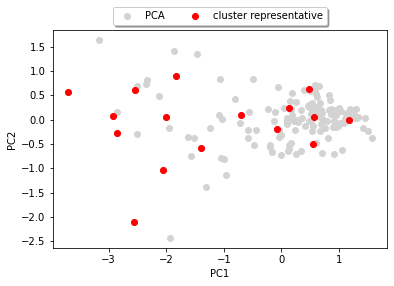

In [56]:
plt.scatter(pca_components[:,0], pca_components[:,1], c="lightgrey")
plt.xlabel("PC1")
plt.ylabel("PC2")

[plt.scatter(pca_components[yr[2],0], pca_components[yr[2],1], c="red") for yr in representatives]

plt.legend(["PCA", "cluster representative"], loc='upper center', bbox_to_anchor=(0.5, 1.13), fancybox=True, shadow=True, ncol=5)

plt.show()

## Plotting centroids

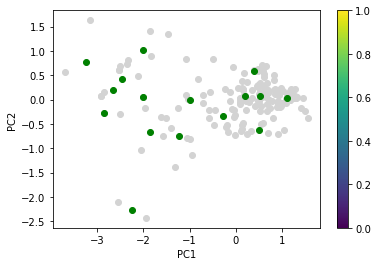

In [57]:
cc = km.cluster_centers_

#plotting all elements
plt.scatter(pca_components_df.iloc[:, 0], pca_components_df.iloc[:, 1], c = "lightgrey")
plt.xlabel("PC1")
plt.ylabel("PC2")

# plotting cluster centers
plt.scatter(cc[:, 0], cc[:, 1], c="green") 
plt.colorbar()
plt.show()